In [1]:
from learningAgent import LearningAlgorithm
from environment import Model
from Qtable import QTable
from policyTable import PolicyTable
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from policyTable import PolicyTable
from play import Tournament
import re
import bimatrix
from fractions import Fraction

In [2]:
np.random.seed(0)

In [3]:
# Parameters for the game:
total_demand = 400
initial_demands = [total_demand/2, total_demand/2]
discount_factor = 1
low_cost = 57
high_cost = 71 
total_stages = 10

In [4]:
# Parameters for the adversary:
number_actions = 60
number_demands = total_demand + 1

In [5]:
high_cost_player = PolicyTable(number_demands,number_actions,high_cost,total_stages)
high_cost_player = high_cost_player.random_reset()
high_cost_probabilities = [1]
high_cost_players = [high_cost_player]
low_cost_players = []

In [6]:
def training(total_demand, discount_factor, costs, total_stages, adversary_probabilities, adversaries, number_episodes):
    
        game = Model(total_demand, costs, total_stages, adversaries, adversary_probabilities)
        constant = int(number_episodes/49)
        Qtable = QTable(total_demand + 1, number_actions, total_stages , learning_rate = [constant,constant])
        algorithm = LearningAlgorithm(game, Qtable, number_episodes, discount_factor)
        
        episode_counter = 0
        number_rounds = 1
        number_episodes_per_round = int(number_episodes / number_rounds)       
        for round_ in range(number_rounds): 
            algorithm.epsilon_greedy_learning(number_episodes_per_round, episode_counter, number_episodes)      
            episode_counter += number_episodes_per_round
        agent = Qtable.to_policy_table(costs[0])
        payoff = 0
        if costs[0] < costs[1]:
            for index, adversary in enumerate(adversaries):
                _, _, payoff_against_adversary, _ = new_equilibrium([agent], [adversary], discount_factor, costs, total_stages, [200,200])
                payoff += (payoff_against_adversary * adversary_probabilities[index])
        else:
            for index, adversary in enumerate(adversaries):
                _, _, _, payoff_against_adversary = new_equilibrium([adversary], [agent], discount_factor, [costs[1],costs[0]], total_stages, [200,200])
                payoff += (payoff_against_adversary * adversary_probabilities[index])    
        return Qtable.to_policy_table(costs[0]), payoff

In [7]:
def new_equilibrium(low_cost_players, high_cost_players, discount_factor, costs, total_stages, initial_demands):
    tournament = Tournament(low_cost_players, high_cost_players, discount_factor, costs, total_stages, initial_demands)
    
    A,B = tournament.run_tournament()
    number_rows = len(A) # Low cost players
    number_columns = len(A[0]) # High cost players
    
    with open('game.txt', 'w') as f:
        f.write(str(number_rows) + " " + str(number_columns))
        f.write('\n')
        f.write('\n')
        for row in A:
            for column in row:
                f.write(np.array2string(np.array(int(column))) + " ")
            f.write('\n')
        f.write('\n')
        for row in B:
            for column in row:
                f.write(np.array2string(np.array(int(column))) + " ")
            f.write('\n')
        f.write('\n')
    game = bimatrix.bimatrix("game.txt")
    equilibrium = game.tracing(100)
    low_cost_probs, high_cost_probs, low_cost_support, high_cost_support = recover_probs(equilibrium)
    low_cost_probabilities = return_distribution(len(low_cost_players), low_cost_probs, low_cost_support)
    high_cost_probabilities = return_distribution(len(high_cost_players), high_cost_probs, high_cost_support)
    low_cost_payoff = np.matmul(low_cost_probabilities, np.matmul(A,np.transpose(high_cost_probabilities)))
    high_cost_payoff = np.matmul(low_cost_probabilities, np.matmul(B,np.transpose(high_cost_probabilities)))
    return low_cost_probabilities, high_cost_probabilities, low_cost_payoff, high_cost_payoff
    

In [8]:
def recover_probs(test):
    low_cost_probs, high_cost_probs, rest = test.split(")")
    low_cost_probs = low_cost_probs.split("(")[1] 
    _, high_cost_probs = high_cost_probs.split("(")
    high_cost_probs = [float(Fraction(s)) for s in high_cost_probs.split(',')]
    low_cost_probs = [float(Fraction(s)) for s in low_cost_probs.split(',')]
    _, low_cost_support, high_cost_support = rest.split('[')
    high_cost_support, _ = high_cost_support.split(']')
    high_cost_support = [int(s) for s in high_cost_support.split(',')]
    low_cost_support, _ = low_cost_support.split(']')
    low_cost_support = [int(s) for s in low_cost_support.split(',')]
    return low_cost_probs, high_cost_probs, low_cost_support, high_cost_support

In [9]:
def return_distribution(number_players, cost_probs, cost_support):
    player_probabilities = [0]* number_players
    for index, support in enumerate(cost_support):
        player_probabilities[support] = cost_probs[support]
    return player_probabilities

In [10]:
low_cost_payoff = 0
high_cost_payoff = 0

In [11]:
number_rounds = 10
number_episodes = 100_000
equilibria = list()

Round 1  of  10
[1.0] [1.0] 4801.3 1940.8
[1.0] [0, 1.0] 4203.2 2345.7


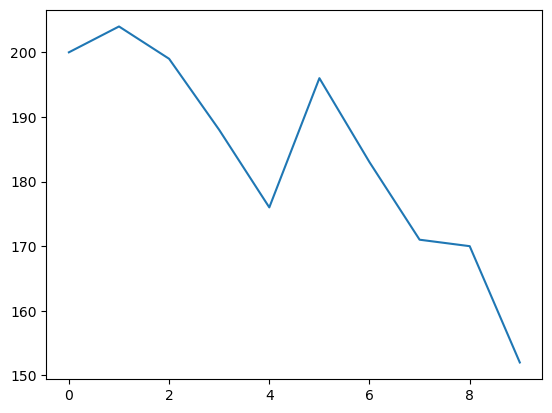

Round 2  of  10
[0, 1.0] [0, 1.0] 5062.2 2388.1
[0, 1.0] [0, 0, 1.0] 5198.3 2623.0


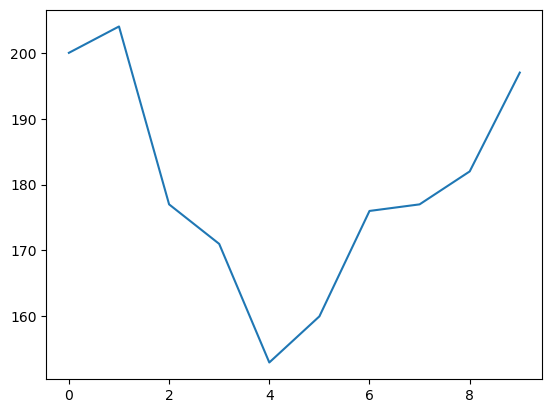

Round 3  of  10


In [12]:
for round_ in range(number_rounds):
    print("Round",round_ + 1, " of ", number_rounds)
    update = False
    
    low_cost_player, payoff = training(total_demand, discount_factor, [low_cost, high_cost], total_stages, high_cost_probabilities, high_cost_players, number_episodes)
    if payoff > low_cost_payoff:
        update = True
        low_cost_players.append(low_cost_player)
        low_cost_probabilities, high_cost_probabilities, low_cost_payoff, high_cost_payoff = new_equilibrium(low_cost_players, high_cost_players, discount_factor, [low_cost, high_cost], total_stages, initial_demands)
        equilibria.append([low_cost_probabilities, high_cost_probabilities, low_cost_payoff, high_cost_payoff])
        print(low_cost_probabilities, high_cost_probabilities, low_cost_payoff, high_cost_payoff)
    
    high_cost_player, payoff = training(total_demand, discount_factor, [high_cost, low_cost], total_stages, low_cost_probabilities, low_cost_players, number_episodes)
    if payoff > high_cost_payoff:
        update = True
        high_cost_players.append(high_cost_player)
        low_cost_probabilities, high_cost_probabilities, low_cost_payoff, high_cost_payoff = new_equilibrium(low_cost_players, high_cost_players, discount_factor, [low_cost, high_cost], total_stages, initial_demands)
        equilibria.append([low_cost_probabilities, high_cost_probabilities, low_cost_payoff, high_cost_payoff])
        print(low_cost_probabilities, high_cost_probabilities, low_cost_payoff, high_cost_payoff)
    
    # Graph the trajectory of the high cost players against the low cost players in the equilibrium.
    if update:
        tournament = Tournament(low_cost_players, high_cost_players, discount_factor, [low_cost, high_cost], total_stages, initial_demands)
        for low_index, low_cost_player in enumerate(low_cost_players):
            for high_index, high_cost_player in enumerate(high_cost_players):
                if low_cost_probabilities[low_index] > 0 and high_cost_probabilities[high_index] > 0:
                    low_demands, high_demands = np.transpose(tournament.return_trajectory(low_cost_player, high_cost_player))
                    plt.plot(high_demands)
            plt.show()
            
    if update:
        number_episodes = 100_000
    else:
        number_episodes += 100_000


In [ ]:
for index, low_cost_player in enumerate(low_cost_players):
    policy_table = PolicyTable(total_demand + 1, number_actions, low_cost, total_stages)
    policy_table.define(low_cost_player)
    policy_table.save("Low Cost " + str(index))
for index, high_cost_player in enumerate(high_cost_players):
    policy_table = PolicyTable(total_demand + 1, number_actions, low_cost, total_stages)
    policy_table.define(high_cost_player)
    policy_table.save("High Cost " + str(index))